In [1]:
import os
import cv2
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import utils
from discriminators import define_Dis
from generators import define_Gen

In [2]:
crop_height = 128
crop_width = 128
dataset_dir = './datasets/sketch2pokemon'
checkpoint_dir = './checkpoints/sketch2pokemon'
checkpoint_name = 'latest'
results_dir = './results'
batch_size = 1
ngf = 64
norm = 'instance'
no_dropout = False
gpu_ids = [0]#[0]

test_length = 5

In [3]:
utils.create_link(dataset_dir)

{'trainA': './datasets/sketch2pokemon\\ltrainA',
 'trainB': './datasets/sketch2pokemon\\ltrainB',
 'testA': './datasets/sketch2pokemon\\ltestA',
 'testB': './datasets/sketch2pokemon\\ltestB'}

In [4]:
transform = transforms.Compose(
    [transforms.Resize((crop_height,crop_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset_dirs = utils.get_testdata_link(dataset_dir)

a_test_data = dsets.ImageFolder(dataset_dirs['testA'], transform=transform)
b_test_data = dsets.ImageFolder(dataset_dirs['testB'], transform=transform)


a_test_loader = torch.utils.data.DataLoader(a_test_data, batch_size=batch_size, shuffle=False, num_workers=4) # set shuffle to false for testing
b_test_loader = torch.utils.data.DataLoader(b_test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Gab = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)
Gba = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)

utils.print_networks([Gab,Gba], ['Gab','Gba'])

Network initialized with weights sampled from N(0,0.02).
Network initialized with weights sampled from N(0,0.02).
------------Number of Parameters---------------
[Network Gab] Total number of parameters : 11.378 M
[Network Gba] Total number of parameters : 11.378 M
-----------------------------------------------


In [5]:
try:
    ckpt = utils.load_checkpoint('%s/%s.ckpt' % (checkpoint_dir, checkpoint_name))
    Gab.load_state_dict(ckpt['Gab'])
    Gba.load_state_dict(ckpt['Gba'])
except:
    print(' [*] No checkpoint!')

 [*] Loading checkpoint from ./checkpoints/sketch2pokemon/latest.ckpt succeed!


In [6]:
a_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainA'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)
b_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainB'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)

In [7]:
def readImage(path):
    return cv2.imread(path)

def computeMetrics(imga, imgb, isPrint=False):
    hsv_base = cv2.cvtColor(imga, cv2.COLOR_BGR2HSV)
    hsv_test1 = cv2.cvtColor(imgb, cv2.COLOR_BGR2HSV)
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    if isPrint:
        print('HistCompare_correlation: ', corr)
        print('HistCompare_chi_square: ', chisq)
        print('HistCompare_intersction: ', intersectn)
        print('HistCompare_bhat: ', bhat)
    
    return corr, chisq, intersectn, bhat
    
# Utils.ssim_score(img1, img2, data_range=1.0)
# Utils.psnr_score(img1, img2)
### Utils.inception_score()

def spatialBinnedMetrics(imga, imgb, num_hor=4, num_ver=4):
    # default 4 x 4
    #assume a and b same shape
    h,w, _ = imga.shape
    dx = int(w / num_hor)
    dy = int(h / num_ver)
    
    corr, chisq, inter, bhat = 0,0,0,0
    for i in range(num_ver):
        for j in range(num_hor):
            patch_a = imga[i*dy : (i+1)*dy, j*dx : (j+1)*dx]
            patch_b = imgb[i*dy : (i+1)*dy, j*dx : (j+1)*dx]
            co, cs, inte, bh = computeMetrics(patch_a, patch_b)
            corr += co
            chisq += cs
            inter += inte
            bhat += bh
    corr /= num_hor * num_ver
    chisq /= num_hor * num_ver
    inter /= num_hor * num_ver
    bhat /= num_hor * num_ver
    
    print("\nfinal: -----")
    print("correlation: ", corr)
    print("chi square: ", chisq)
    print("intersection: ", inter)
    print("bhat: ", bhat)
    
    return corr, chisq, inter, bhat
            
            
#     raise NotImplementedError()


final: -----
correlation:  0.3425067914671823
chi square:  69.82688479531737
intersection:  0.6965580734540708
bhat:  0.757381937877794

final: -----
correlation:  0.23578008233251135
chi square:  61.512795997477355
intersection:  0.4752978923934279
bhat:  0.8099900201807584

final: -----
correlation:  0.2937919736254034
chi square:  49.589535723910686
intersection:  0.6681966850737808
bhat:  0.7801533523616303

final: -----
correlation:  0.2522457473051185
chi square:  59.1207187219289
intersection:  0.4560984113632003
bhat:  0.8054041164552392

final: -----
correlation:  0.23433901740939872
chi square:  38.11667159928167
intersection:  0.5048968901101034
bhat:  0.8165285852902262

final: -----
correlation:  0.3562018697118856
chi square:  18.699539442023397
intersection:  0.6662489502996323
bhat:  0.8034844232570711

final: -----
correlation:  0.2746525974879301
chi square:  21.350953742848663
intersection:  0.6377800458212732
bhat:  0.7870010117491563

final: -----
correlation:  0.

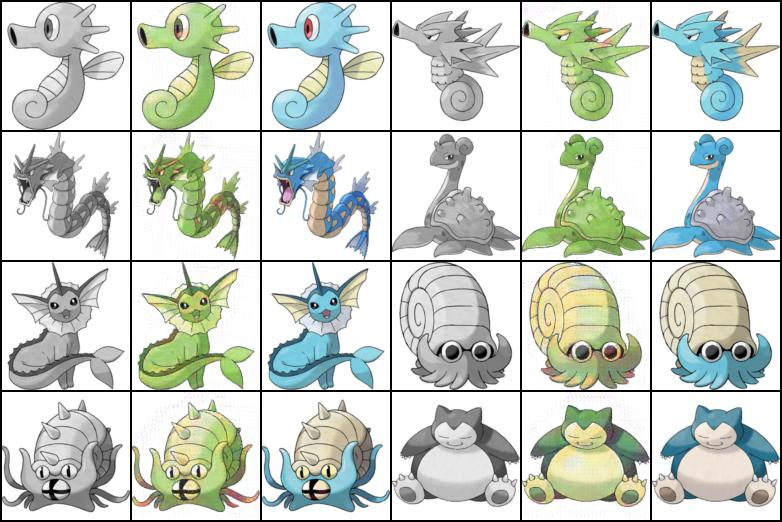

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

def gen(idx=0):
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    for i in range(idx+1):
        a = itera.next()
        b = iterb.next()
    a_real_test = Variable(a[0], requires_grad=True)
    b_real_test = Variable(b[0], requires_grad=True)
    a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
            

    Gab.eval()
    Gba.eval()

    with torch.no_grad():
        a_fake_test = Gab(b_real_test)
        b_fake_test = Gba(a_real_test)
        a_recon_test = Gab(b_fake_test)
        b_recon_test = Gba(a_fake_test)

        pic = (torch.cat([a_real_test, b_fake_test], dim=0).data + 1) / 2.0

        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

        torchvision.utils.save_image(pic, results_dir+'/sample_%d.jpg' % idx, nrow=3)

def print_test(length):
    correlation_scores, intersection_scores, bhat_scores = np.empty(length), np.empty(length), np.empty(length)
    
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    res = []
    for i in range(length):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
        Gab.eval()
        Gba.eval()

        with torch.no_grad():
            a_fake_test = Gab(b_real_test)
            b_fake_test = Gba(a_real_test)
            a_recon_test = Gab(b_fake_test)
            b_recon_test = Gba(a_fake_test)
            
            # ADD METRICS
            corr, chisq, inter, bhat = spatialBinnedMetrics(b_fake_test.data.squeeze(0).permute(1, 2, 0).cpu().numpy(), 
                                                            b_real_test.data.squeeze(0).permute(1, 2, 0).cpu().numpy(), 
                                                            num_hor=4, num_ver=4)
            correlation_scores[i] = corr
            intersection_scores[i] = inter
            bhat_scores[i] = bhat

            res.extend([a_real_test, b_fake_test, b_real_test])

    cs_std = np.std(correlation_scores)
    cs_mean = np.mean(correlation_scores)
    is_std = np.std(intersection_scores)
    is_mean = np.mean(intersection_scores)
    bs_std = np.std(bhat_scores)
    bs_mean = np.mean(bhat_scores)
    print("----- AGGREGATE SCORES -----")
    print("Correlation: ", cs_mean, " +- ", cs_std)
    print("Intersection: ", is_mean, " +- ", is_std)
    print("Bhat score: ", bs_mean, " +- ", bs_std)
    print("\n----- INDIVIDUAL SCORES -----")
    print("### Corr")
    print(correlation_scores)
    print("### Inter")
    print(intersection_scores)
    print("### Bhat")
    print(bhat_scores)
    
    pic = (torch.cat(res, dim=0).data + 1) / 2.0

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    torchvision.utils.save_image(pic, results_dir+'/result_%d.jpg' % ckpt['epoch'], nrow=6)

# idx = 16
# gen(idx)
# from IPython.display import Image
# Image(filename=results_dir+'/sample_%d.jpg' % idx) 

print_test(8)

from IPython.display import Image
Image(filename=results_dir+'/result_%d.jpg' % ckpt['epoch']) 

# RUN THIS FOR METRICS YA :]

In [9]:
def readImage(path):
    return cv2.imread(path)

def computeMetrics(imga, imgb, isPrint=False):
    hsv_base = cv2.cvtColor(imga, cv2.COLOR_BGR2HSV)
    hsv_test1 = cv2.cvtColor(imgb, cv2.COLOR_BGR2HSV)
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    if isPrint:
        print('HistCompare_correlation: ', corr)
        print('HistCompare_chi_square: ', chisq)
        print('HistCompare_intersction: ', intersectn)
        print('HistCompare_bhat: ', bhat)
    
    return corr, chisq, intersectn, bhat
    
# Utils.ssim_score(img1, img2, data_range=1.0)
# Utils.psnr_score(img1, img2)
### Utils.inception_score()

def spatialBinnedMetrics(imga, imgb, num_hor=4, num_ver=4):
    # default 4 x 4
    #assume a and b same shape
    h,w, _ = imga.shape
    dx = int(w / num_hor)
    dy = int(h / num_ver)
    
    corr, chisq, inter, bhat = 0,0,0,0
    for i in range(num_ver):
        for j in range(num_hor):
            patch_a = imga[i*dy : (i+1)*dy, j*dx : (j+1)*dx]
            patch_b = imgb[i*dy : (i+1)*dy, j*dx : (j+1)*dx]
            co, cs, inte, bh = computeMetrics(patch_a, patch_b)
            corr += co
            chisq += cs
            inter += inte
            bhat += bh
    corr /= num_hor * num_ver
    chisq /= num_hor * num_ver
    inter /= num_hor * num_ver
    bhat /= num_hor * num_ver
    
    print("\nfinal: -----")
    print("correlation: ", corr)
    print("chi square: ", chisq)
    print("intersection: ", inter)
    print("bhat: ", bhat)
    
    return corr, chisq, inter, bhat
            
            
#     raise NotImplementedError()

In [10]:
def compareImages(res_test_loader, actual_test_loader):
    length = len(res_test_loader)
    correlation_scores, intersection_scores, bhat_scores = np.empty(length), np.empty(length), np.empty(length)
    
    itera = iter(res_test_loader)
    iterb = iter(actual_test_loader)
    for i in range(length):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        
        print("###", i, " ###")
        corr, chisq, inter, bhat = spatialBinnedMetrics(a_real_test.data.squeeze(0).permute(1, 2, 0).numpy(), b_real_test.data.squeeze(0).permute(1, 2, 0).numpy(), num_hor=4, num_ver=4)
        correlation_scores[i] = corr; intersection_scores[i] = inter; bhat_scores[i] = bhat

    cs_std = np.std(correlation_scores)
    cs_mean = np.mean(correlation_scores)
    is_std = np.std(intersection_scores)
    is_mean = np.mean(intersection_scores)
    bs_std = np.std(bhat_scores)
    bs_mean = np.mean(bhat_scores)
    print("----- AGGREGATE SCORES -----")
    print("Correlation: ", cs_mean, " +- ", cs_std)
    print("Intersection: ", is_mean, " +- ", is_std)
    print("Bhat score: ", bs_mean, " +- ", bs_std)
    print("\n----- INDIVIDUAL SCORES -----")
    print("### Corr")
    print(correlation_scores)
    print("### Inter")
    print(intersection_scores)
    print("### Bhat")
    print(bhat_scores)

In [11]:
### This is an example call after loading the test_loaders as in cell 4 on top
compareImages(a_test_loader, b_test_loader)

### 0  ###

final: -----
correlation:  0.7236126643124855
chi square:  0.09897040673679211
intersection:  0.8374435091391206
bhat:  0.5179918153183981
### 1  ###

final: -----
correlation:  0.8025495598981142
chi square:  0.09554341176172021
intersection:  0.879054750315845
bhat:  0.41148625336650435
### 2  ###

final: -----
correlation:  0.882258296670881
chi square:  0.0755074884906477
intersection:  0.9052479322999716
bhat:  0.4106254290586581
### 3  ###

final: -----
correlation:  0.8374311718336156
chi square:  0.03620423149135599
intersection:  0.9230182394385338
bhat:  0.38119196681007406
### 4  ###

final: -----
correlation:  0.7309927807474267
chi square:  0.18798885503527243
intersection:  0.7656643313821405
bhat:  0.4935132220929165
### 5  ###

final: -----
correlation:  0.740710199143273
chi square:  0.23805280802135304
intersection:  0.7156741991639137
bhat:  0.5101109913701953
### 6  ###

final: -----
correlation:  0.7514877259731629
chi square:  0.18872527881617973
inter

## Metrics

Test and generate colourings --> then use metric

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import eval_utils as Utils

In [ ]:
def readImage(path):
    return cv2.imread(path)

def computeMetrics(imga, imgb, isPrint=False):
    hsv_base = cv2.cvtColor(imga, cv2.COLOR_BGR2HSV)
    hsv_test1 = cv2.cvtColor(imgb, cv2.COLOR_BGR2HSV)
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    if isPrint:
        print('HistCompare_correlation: ', corr)
        print('HistCompare_chi_square: ', chisq)
        print('HistCompare_intersction: ', intersectn)
        print('HistCompare_bhat: ', bhat)
    
    return corr, chisq, intersectn, bhat
    
# Utils.ssim_score(img1, img2, data_range=1.0)
# Utils.psnr_score(img1, img2)
### Utils.inception_score()

def spatialBinnedMetrics(imga, imgb, num_hor=4, num_ver=4):
    # default 4 x 4
    #assume a and b same shape
    print(imga.shape)
    h,w, _ = imga.shape
    dx = int(w / num_hor)
    dy = int(h / num_ver)
    
    corr, chisq, inter, bhat = 0,0,0,0
    for i in range(num_ver):
        for j in range(num_hor):
            patch_a = imga[i*dy : (i+1)*dy, j*dx : (j+1)*dx]
            patch_b = imgb[i*dy : (i+1)*dy, j*dx : (j+1)*dx]
            co, cs, inte, bh = computeMetrics(patch_a, patch_b)
            corr += co
            chisq += cs
            inter += inte
            bhat += bh
    corr /= num_hor * num_ver
    chisq /= num_hor * num_ver
    inter /= num_hor * num_ver
    bhat /= num_hor * num_ver
    
    print("\nfinal: -----")
    print("correlation: ", corr)
    print("chi square: ", chisq)
    print("intersection: ", inter)
    print("bhat: ", bhat)
    
    return corr, chisq, inter, bhat
            
            
#     raise NotImplementedError()

In [ ]:
pokemon = ['lapras, omastar, staryu, dunspace'] #bbyy
testevaldir = './datasets/test_metrics/'
imgType = ['_grey.jpg', '_res.jpg', '.jpg']

In [ ]:
# img1path = './datasets/sketch2pokemon/testB/90_B.jpg'
# img2path = './datasets/sketch2pokemon/testB/91_B.jpg'
# poke = pokemon[0]
# img2path = testevaldir+poke+imgType[2]
# img1path = testevaldir+poke+imgType[0]
img1path = './datasets/test_metrics/omastar_grey.jpg'
img2path = './datasets/test_metrics/omastar_res.jpg'
img3path = './datasets/test_metrics/omastar.jpg'

imga = readImage(img1path)
imgb = readImage(img2path)
imgc = readImage(img3path)

plt.subplot(131)
plt.imshow(imga)
plt.subplot(132)
plt.imshow(imgb)
plt.subplot(133)
plt.imshow(imgc)
plt.show()

In [ ]:
def eval_print(label, img1, img2, isPrint=False):
    print(label, "-----")
    print("ssim: ", Utils.ssim_score(img1, img2, data_range=1.0))
    print("psnr: ", Utils.psnr_score(img1, img2))
    computeMetrics(img1, img2, isPrint=isPrint)

### Dunspace eg

In [ ]:
eval_print("# GREY", imga, imgc) #dunspace
eval_print('# RES', imgb, imgc)
eval_print('# IDENTITY', imgc, imgc)

In [ ]:
spatialBinnedMetrics(imga, imgc)
spatialBinnedMetrics(imgb, imgc)
spatialBinnedMetrics(imgc, imgc)

### Staryu eg

In [ ]:
eval_print("# GREY", imga, imgc) #staryu
eval_print('# RES', imgb, imgc)
eval_print('# IDENTITY', imgc, imgc)

In [ ]:
spatialBinnedMetrics(imga, imgc)
spatialBinnedMetrics(imgb, imgc)
spatialBinnedMetrics(imgc, imgc)

### lapras eg

In [ ]:
eval_print("# GREY", imga, imgc, isPrint=True) #lapras
eval_print('# RES', imgb, imgc, isPrint=True)
eval_print('# IDENTITY', imgc, imgc, isPrint=True)

In [ ]:
spatialBinnedMetrics(imga, imgc)
spatialBinnedMetrics(imgb, imgc)
spatialBinnedMetrics(imgc, imgc)

### omastar eg

In [ ]:
eval_print("# GREY", imga, imgc, isPrint=True) #lapras
eval_print('# RES', imgb, imgc, isPrint=True)
eval_print('# IDENTITY', imgc, imgc, isPrint=True)

In [ ]:
spatialBinnedMetrics(imga, imgc)
spatialBinnedMetrics(imgb, imgc)
spatialBinnedMetrics(imgc, imgc)

### Dump

In [ ]:
computeMetrics(imga, imgb) #exact same ghastly

In [ ]:
computeMetrics(imga, imgb) #onix onix

from here can see that intersection and bhat is not ideal cus dif values despite identity

In [ ]:
computeMetrics(imga, imgb) #ghastly haunter

In [ ]:
computeMetrics(imga, imgb) #ghastly gengar

In [ ]:
computeMetrics(imga, imgb) #ghastly onix

In [ ]:
computeMetrics(imga, imgb) #ghastly mutant_drowzee

chisq seems gd ah

In [ ]:
computeMetrics(imga, imgb) #ghastly caterpie

# Dump (to ignore)

In [ ]:
def save_sample_image(test_length):
    temp_dir = './temp'
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    res = []
    average_hist_score_correlation = 0.0
    average_hist_score_chi_square = 0.0
    average_hist_score_intersction = 0.0
    average_hist_score_bhat = 0.0
    for i in range(test_length):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
        Gab.eval()
        Gba.eval()

        with torch.no_grad():
            # a_fake_test = self.Gab(b_real_test)
            b_fake_test = Gba(a_real_test)
            # a_recon_test = self.Gab(b_fake_test)
            # b_recon_test = self.Gba(a_fake_test)

            res.extend([a_real_test, b_fake_test, b_real_test])

            ##### Generate histogram similarity score
            # Documentation: https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html
            torchvision.utils.save_image(b_fake_test.cpu(), temp_dir + '/model_output' + i + '.jpg')
            torchvision.utils.save_image(b_real_test.cpu(), temp_dir + '/groundtruth' + i + '.jpg')
            src_base = cv2.imread(temp_dir + '/groundtruth.jpg')
            src_test1 = cv2.imread(temp_dir + '/model_output.jpg')
            hsv_base = cv2.cvtColor(src_base, cv2.COLOR_BGR2HSV)
            hsv_test1 = cv2.cvtColor(src_test1, cv2.COLOR_BGR2HSV)
            h_bins = 50
            s_bins = 60
            v_bins = 60
            histSize = [h_bins, s_bins, v_bins]
            # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
            h_ranges = [0, 180]
            s_ranges = [0, 256]
            v_ranges = [0, 256]
            ranges = h_ranges + s_ranges + v_ranges# concat lists
            # Use 0,1,2nd channels
            channels = [0, 1, 2]
            hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
            cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
            cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
            corr = cv2.compareHist(hist_base, hist_test1, 0)
            average_hist_score_correlation += corr
            chisq = cv2.compareHist(hist_base, hist_test1, 1)
            average_hist_score_chi_square += chisq
            intersectn = cv2.compareHist(hist_base, hist_test1, 2)
            average_hist_score_intersction += intersectn
            bhat = cv2.compareHist(hist_base, hist_test1, 3)
            average_hist_score_bhat += bhat
            # os.remove(temp_dir + '/model_output.jpg')
            # os.remove(temp_dir + '/groundtruth.jpg')
            print('HistCompare_correlation: ', corr)
            print('HistCompare_chi_square: ', chisq)
            print('HistCompare_intersction: ', intersectn)
            print('HistCompare_bhat: ', bhat)

    print('aveHistCompare_correlation: ', average_hist_score_correlation / test_length)
    print('aveHistCompare_chi_square: ', average_hist_score_chi_square / test_length)
    print('aveHistCompare_intersction: ', average_hist_score_intersction / test_length)
    print('aveHistCompare_bhat: ', average_hist_score_bhat / test_length)


In [ ]:
save_sample_image(5)